In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

### Load Data

In [12]:
SEISMIC_DATA = '/Users/pmh/Desktop/cushingSeismic.hdf5'
PRESSURE_DATA = '/Users/pmh/Desktop/cushingPressure.hdf5'

In [13]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [14]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [15]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: /Users/pmh/Desktop/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [16]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [17]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25
t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [18]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated)

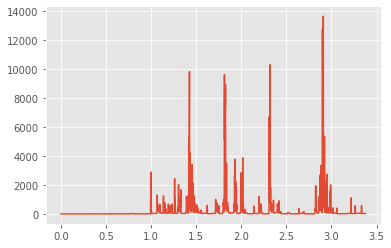

In [19]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
plt.plot(t_p_interpolated, empirical_rate)

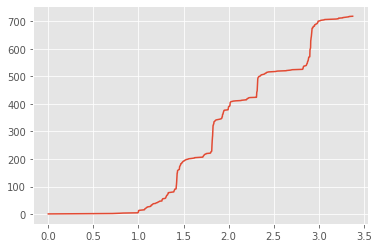

In [20]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [21]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

In [22]:
n_target = torch.FloatTensor(n_interpolated)[:train_end]
p = torch.FloatTensor(p)[:train_end]
dpdt = torch.FloatTensor(dpdt)[:train_end]
delta_t = torch.FloatTensor(delta_t)[:train_end]

### Define site constants

In [23]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400

site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item()
}

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [24]:
mu_minus_alpha_mesh = torch.linspace(0.1, 1.0, 101)
rate_coeff_mesh = 10 ** torch.linspace(-4, -1, 101)
grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

params = torch.stack([
    grid_mu.flatten(),
    grid_rate.flatten(),
    163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
]).T

#We will test gradient functionality later
params.requires_grad_();

### Run Model

In [25]:
from saif.crs_model.model import CRSModel

In [26]:
model = CRSModel(site_info)

In [27]:
Rt, Nt = model(params, p, dpdt, delta_t)

Visualize a sample

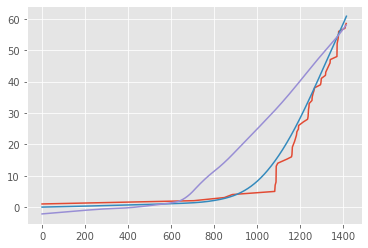

In [39]:
plt.plot(n_target)

plt.plot(Nt[5500].data)
plt.plot(p/20000-60)

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [36]:
criterion = nn.MSELoss(reduction='none')

In [37]:
mse_vals = criterion(
    Nt[:,1:], 
    n_target.repeat(Nt.shape[0], 1)
).mean(-1)

losses = mse_vals.data.numpy()

Plot the landscape

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


Text(0, 0.5, '$\\mathrm{log}(a)$')

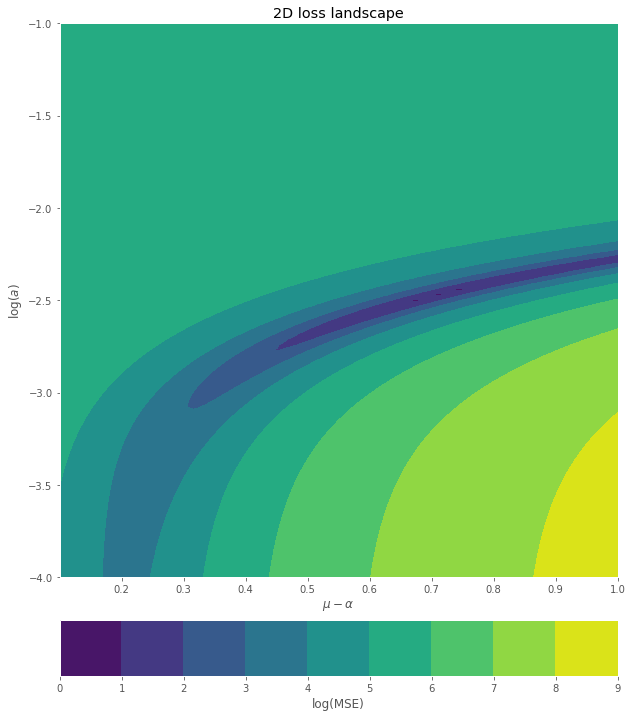

In [39]:

fig, ax = plt.subplots(1,1,figsize=(10,12))
plt.title('2D loss landscape')

c = ax.contourf(
    grid_mu.numpy(), np.log(grid_rate.numpy()) / np.log(10),
    np.log(losses.reshape(grid_mu.numpy().shape))
)


divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='10%', pad=0.6)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cax.set_xlabel('log(MSE)')  # cax == cb.ax



ax.set_xlabel(r'$\mu - \alpha$')
ax.set_ylabel(r'$\mathrm{log}(a)$')



Test gradient

This takes a while to run on my tiny tablet.

In [40]:
# total_loss = mse_vals.sum()
# total_loss.backward()
# params.grad.data